<a href="https://colab.research.google.com/github/AtlantisAnalytics/Grad-CAM/blob/main/Grad_CAM_Explainable_AI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explaining Neural Network Predictions with PyTorch and Grad-CAM

NOTE: Pre-trained model might not always make correct predictions, especially if the training data does not adequately represent the variety of examples it encounters during inference. In such cases, improve the model's performance by fine-tuning it on a more diverse dataset or employing techniques like data augmentation to increase the variety of training examples.

### **Objective**: To implement an end-to-end project using the library PyTorch and the Gradient-weighted Class Activation Mapping (Grad-CAM) technique to create explanations for neural network predictions on the ImageNet dataset.

#### **Introduction**
In this project, we will use PyTorch, a popular open-source deep learning framework, and Grad-CAM, a technique for generating visual explanations from a neural network's predictions. We will focus on image classification using a pre-trained model on the ImageNet dataset.

#### **Prerequisites**

Basic understanding of deep learning and convolutional neural networks (CNNs)
Familiarity with Python programming
PyTorch and torchvision installed

In [ ]:
import torch
import torchvision
from torchvision import models, transforms
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

#### Load Pre-trained Model
Load a pre-trained CNN model from torchvision. For example, ResNet-50.

In [ ]:
model = models.resnet50(pretrained=True)
model.eval()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 184MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Preprocess Image
Preprocess the input image to match the format expected by the model.

In [ ]:
def preprocess_image(image_path):
    img = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = preprocess(img).unsqueeze(0)
    return img_tensor

#### Implement Grad-CAM

In [ ]:
class GradCAM:
    def __init__(self, model):
        self.model = model
        self.gradients = None
        self.model.eval()

    def save_gradient(self, grad):
        self.gradients = grad

    def forward(self, x):
        self.model.zero_grad()
        x.requires_grad_()
        out = self.model(x)
        return out

    def generate_cam(self, image_tensor, target_class):
        output = self.forward(image_tensor)
        one_hot_output = torch.zeros((1, output.size()[-1]), dtype=torch.float)
        one_hot_output[0][target_class] = 1
        output.backward(gradient=one_hot_output)

        gradients = self.gradients.detach().cpu().numpy()
        feature_maps = self.model.feature_maps.detach().cpu().numpy()

        cam_weights = np.mean(gradients, axis=(2, 3))[0, :]
        cam = np.zeros(feature_maps.shape[2:], dtype=np.float32)

        for i, weight in enumerate(cam_weights):
            cam += weight * feature_maps[0, i, :, :]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (224, 224))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)

        return cam

#### Register Hooks


In [ ]:
def register_hooks(model, grad_cam):
    def forward_hook(module, input, output):
        grad_cam.model.feature_maps = output

    def backward_hook(module, grad_input, grad_output):
        grad_cam.save_gradient(grad_output[0])

    for name, module in model.named_modules():
        if isinstance(module, torch.nn.modules.conv.Conv2d):
            target_module = module

    target_module.register_forward_hook(forward_hook)
    target_module.register_backward_hook(backward_hook)

#### Apply Grad-CAM

In [ ]:
def apply_grad_cam(image_path, model, grad_cam):
    # Load and preprocess image
    image_tensor = preprocess_image(image_path)

    # Register hooks for Grad-CAM
    register_hooks(model, grad_cam)

    # Get the prediction from the model
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        top_prob, top_class = probabilities.topk(1, dim=1)

    # Generate Grad-CAM
    cam = grad_cam.generate_cam(image_tensor, top_class.item())

    # Load the original image and overlay Grad-CAM
    original_image = cv2.imread(image_path)
    original_image = cv2.resize(original_image, (224, 224))
    cam_heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    overlayed_image = cv2.addWeighted(original_image, 0.5, cam_heatmap, 0.5, 0)

    return top_class.item(), top_prob.item(), cam_heatmap, overlayed_image


#### Download and load Imagenet classes

In [ ]:
import urllib

def download_imagenet_labels():
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    urllib.request.urlretrieve(url, "imagenet_classes.txt")


def load_imagenet_labels():
    with open("imagenet_classes.txt", "r") as f:
        labels = [line.strip() for line in f.readlines()]
    return labels

#### Visualize Results

In [ ]:
def visualize_results(image_path, model, grad_cam):
    download_imagenet_labels()
    imagenet_labels = load_imagenet_labels()

    top_class, top_prob, cam_heatmap, overlayed_image = apply_grad_cam(image_path, model, grad_cam)
    class_label = imagenet_labels[top_class]

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(Image.open(image_path))
    ax[0].axis('off')
    ax[0].set_title('Original Image')

    ax[1].imshow(cam_heatmap)
    ax[1].axis('off')
    ax[1].set_title('Grad-CAM Heatmap')

    ax[2].imshow(overlayed_image)
    ax[2].axis('off')
    ax[2].set_title(f'Overlayed Image (Class: {class_label}, Prob: {top_prob:.4f})')

    plt.show()


#### Download Test images

In [ ]:
!wget "https://cdn.vox-cdn.com/thumbor/IZ7fpJNSeEO1v2vNapVlLYlCWzc=/214x0:1037x549/1200x800/filters:focal(214x0:1037x549)/cdn.vox-cdn.com/uploads/chorus_image/image/45200072/new-ford-gt-supercar-0006.0.0.jpg" -O "car.jpg"
!wget "https://wallpapercave.com/wp/7GnAy3T.jpg" -O "car1.jpg"
!wget "https://inspirationseek.com/wp-content/uploads/2016/02/Cute-Dog-Bring-Yellow-Rose-1024x768.jpg" -O "dog.jpg"
!wget "http://images6.fanpop.com/image/photos/39000000/Cat-cats-39082303-1680-1050.jpg" -O "cat.jpg"
!wget "https://wallsdesk.com/wp-content/uploads/2017/01/Sunflower-HD-Desktop.jpg" -O "flower.jpg"
!wget "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Ftse4.mm.bing.net%2Fth%3Fid%3DOIP.1xb6tlHq2kVDaOexKtA7ngHaFj%26pid%3DApi&f=1&ipt=46803657fee277ea75f7406121bf4a3fbf31fb0bafd90db1fdeb3ad06988a264&ipo=images" -O "rose.jpg"


--2023-04-17 23:43:40--  https://cdn.vox-cdn.com/thumbor/IZ7fpJNSeEO1v2vNapVlLYlCWzc=/214x0:1037x549/1200x800/filters:focal(214x0:1037x549)/cdn.vox-cdn.com/uploads/chorus_image/image/45200072/new-ford-gt-supercar-0006.0.0.jpg
Resolving cdn.vox-cdn.com (cdn.vox-cdn.com)... 199.232.192.124, 199.232.196.124
Connecting to cdn.vox-cdn.com (cdn.vox-cdn.com)|199.232.192.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114723 (112K) [image/jpeg]
Saving to: ‘car.jpg’

car.jpg             100%[===================>] 112.03K  --.-KB/s    in 0.01s   

2023-04-17 23:43:40 (7.79 MB/s) - ‘car.jpg’ saved [114723/114723]

--2023-04-17 23:43:40--  https://wallpapercave.com/wp/7GnAy3T.jpg
Resolving wallpapercave.com (wallpapercave.com)... 104.22.52.71, 104.22.53.71, 172.67.29.26, ...
Connecting to wallpapercave.com (wallpapercave.com)|104.22.52.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282830 (276K) [image/jpeg]
Saving to: ‘car1.jpg’

car1.jp

#### Test Grad-CAM
Use an image to test the Grad-CAM implementation and visualize the results.

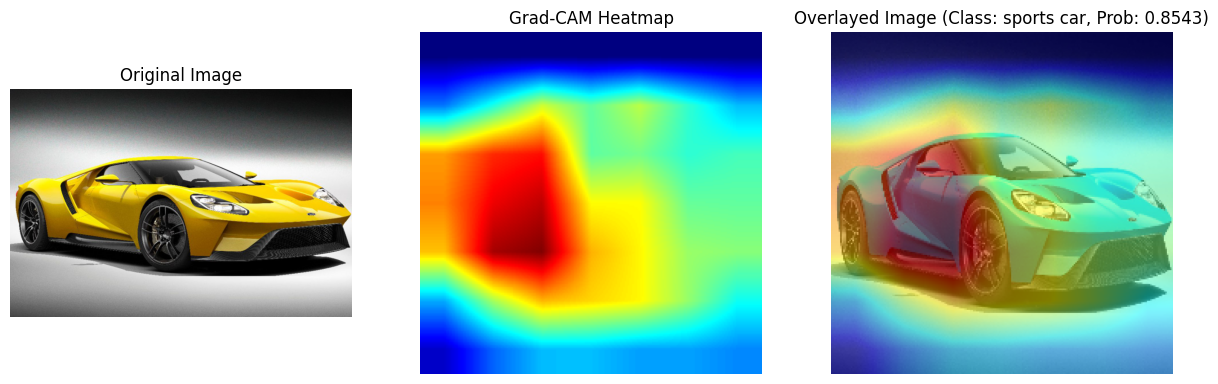

In [ ]:
image_path = 'car.jpg'
grad_cam = GradCAM(model)
visualize_results(image_path, model, grad_cam)

/usr/local/lib/python3.9/dist-packages/torch/nn/modules/module.py:1344: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


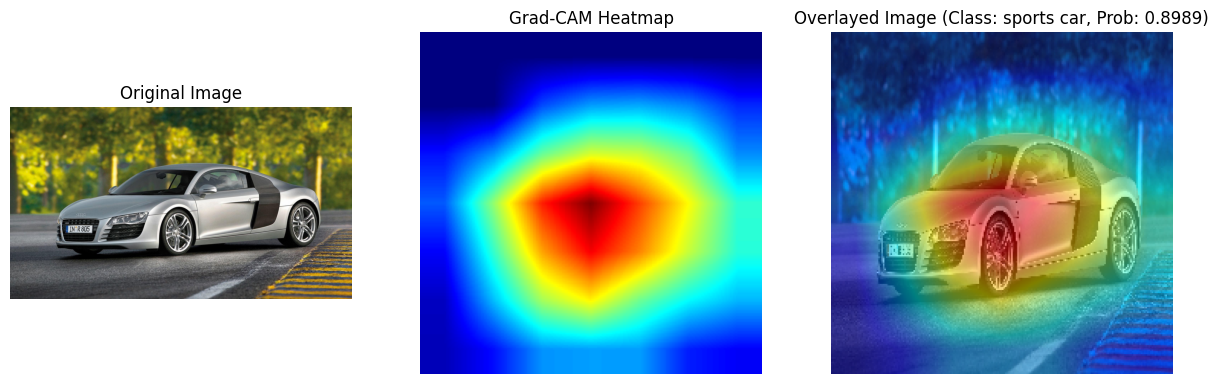

In [ ]:
image_path = 'car1.jpg'
grad_cam = GradCAM(model)
visualize_results(image_path, model, grad_cam)

## Conclusion:

Explainable AI aims to make the decisions made by machine learning models understandable by humans. In the case of the Grad-CAM technique, we visualize which regions in the input image contribute the most to the model's final prediction. However, Grad-CAM doesn't necessarily improve the model's performance or fix incorrect predictions.




#### Cat picture predicted as a tiger:
The model has identified specific features within the image that resemble a tiger cat. The model's convolutional layers are responsible for detecting patterns, textures, and shapes that help it differentiate between classes. In this case, the patterns and colors of the cat's fur resemble those of a tiger cat, leading the model to make this prediction.


Although according to heatmap its not focusing on the core part to predict yet identifying the image correctly.


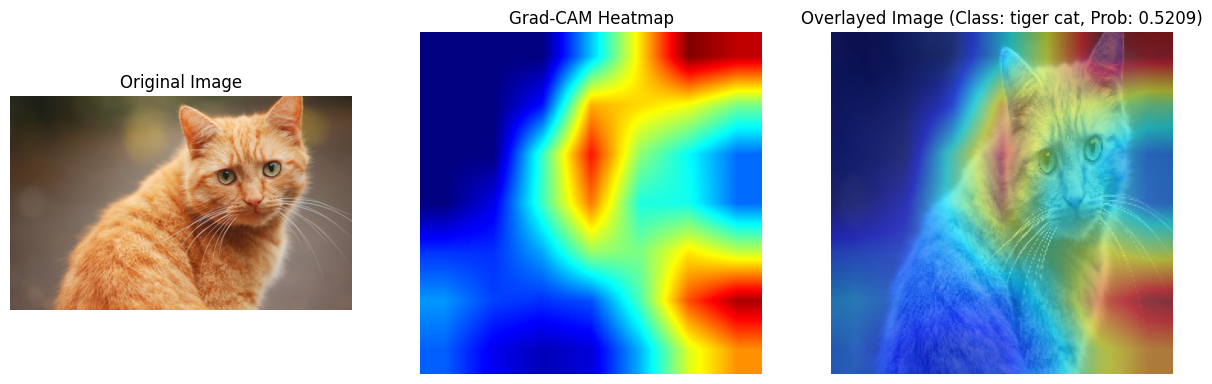

In [ ]:
image_path = 'cat.jpg'
grad_cam = GradCAM(model)
visualize_results(image_path, model, grad_cam)

#### Dog holding a flower predicted as a Labrador Retriever:
The model might be looking at the dog's features (e.g., fur, shape, and color) and identifying it as a Labrador Retriever. The flower might not have a significant impact on the model's decision, but Grad-CAM can help visualize which parts of the image contribute to the prediction. In this case, the model's prediction seems correct.

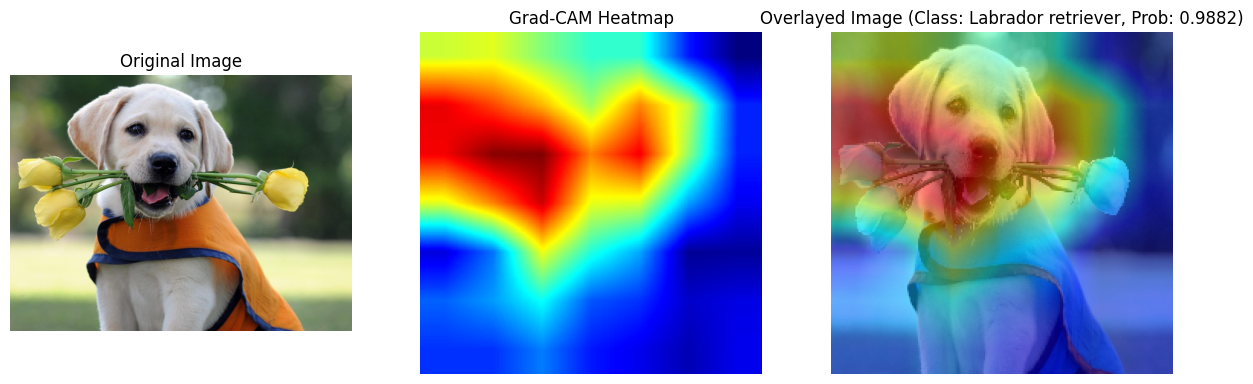

In [ ]:
image_path = 'dog.jpg'
grad_cam = GradCAM(model)
visualize_results(image_path, model, grad_cam)

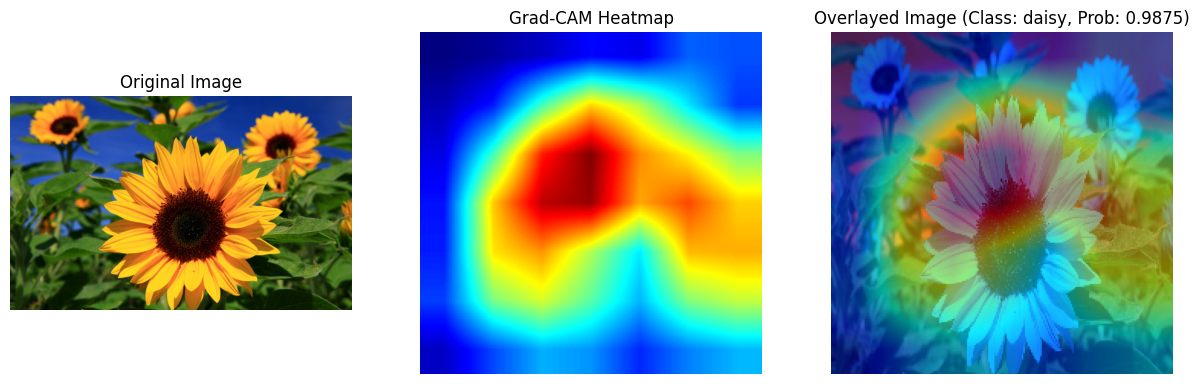

In [ ]:
image_path = 'flower.jpg'
grad_cam = GradCAM(model)
visualize_results(image_path, model, grad_cam)


#### Rose picture predicted as a pot:
The model is focusing on the region by the shape of roses as placed looks like a pot or vase, leading to an incorrect prediction. Grad-CAM highlights the regions the model uses for its decision.


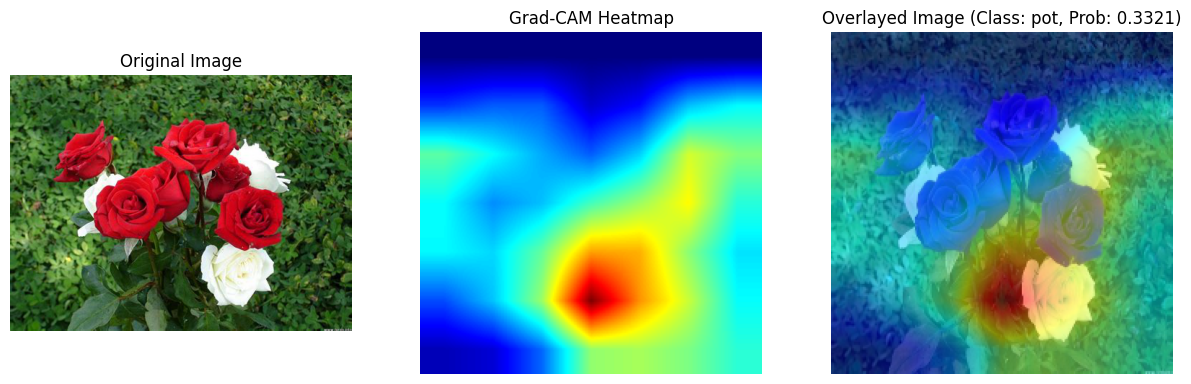

In [ ]:
image_path = 'rose.jpg'
grad_cam = GradCAM(model)
visualize_results(image_path, model, grad_cam)

In summary, Grad-CAM helps us understand which regions of the input image influence the model's predictions, but it does not improve the model's performance. Incorrect predictions can still happen due to various reasons, such as similar features between classes or the model's lack of exposure to specific examples during training. To further improve the model's performance and predictions, techniques like fine-tuning, data augmentation, or using a more advanced architecture can be employed.